# Method Comparison Over Time: When Does Averaging Become Viable?

## Objective
Demonstrate how the **optimal method changes over simulation time** using the dynamic_phasor framework:
- **Early (transient)**: Instantaneous is better
- **Late (steady-state)**: Averaging becomes competitive
- **Hybrid switching**: Gets the best of both worlds

## Key Outputs for APEC Paper
1. **Time-evolution of error** for each strategy
2. **Cumulative computational cost** comparison
3. **Crossover point** where averaging becomes viable
4. **Efficiency gain** from hybrid switching

---

In [11]:
# ============================================================
# CELL 1: Imports and Setup
# ============================================================
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import uniform_filter1d
from dataclasses import dataclass
from typing import Dict, List
import warnings
warnings.filterwarnings('ignore')

# Import our framework
sys.path.insert(0, '../')
from core.circuit import RLCCircuit, CircuitParameters
from core.phasor import InstantaneousPhasor, GeneralizedAveraging, PhasorConfig

# Set random seed
np.random.seed(42)

# Publication-quality plot settings
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'figure.figsize': (12, 8),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'lines.linewidth': 2,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 11,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11
})

# Color scheme for paper
COLORS = {
    'instantaneous': '#E74C3C',  # Red
    'averaging': '#3498DB',       # Blue
    'hybrid': '#27AE60',          # Green
    'ground_truth': '#2C3E50',    # Dark gray
    'transient': '#F39C12',       # Orange
    'steady_state': '#9B59B6'     # Purple
}

print("✓ Framework loaded successfully")
print(f"  NumPy: {np.__version__}")

✓ Framework loaded successfully
  NumPy: 2.3.5


---
## 1. Setup Circuit and Simulation Parameters

In [12]:
# ============================================================
# CELL 2: Circuit Configuration
# ============================================================

# Simulation parameters
OMEGA_S = 580e3    # Operating frequency (rad/s)
T_END = 5e-3       # 5 ms simulation
N_POINTS = 5000    # Time points

# Create circuit with Rim et al. parameters
params = CircuitParameters(
    L=100.04e-6,   # 100.04 µH
    C=30.07e-9,    # 30.07 nF
    Rs=3.0,        # 3.0 Ω
    Ro=2000.0      # 2.00 kΩ
)

print("Circuit Parameters:")
print(f"  L = {params.L*1e6:.2f} µH")
print(f"  C = {params.C*1e9:.2f} nF")
print(f"  Rs = {params.Rs} Ω")
print(f"  Ro = {params.Ro/1e3:.2f} kΩ")
print(f"  Resonant freq: {params.f_r/1e3:.2f} kHz")
print(f"  Q factor: {params.Q:.2f}")
print(f"\nSimulation:")
print(f"  ω_s = {OMEGA_S/1e3:.0f} krad/s")
print(f"  Duration = {T_END*1e3:.1f} ms")
print(f"  Points = {N_POINTS}")

Circuit Parameters:
  L = 100.04 µH
  C = 30.07 nF
  Rs = 3.0 Ω
  Ro = 2.00 kΩ
  Resonant freq: 91.76 kHz
  Q factor: 19.23

Simulation:
  ω_s = 580 krad/s
  Duration = 5.0 ms
  Points = 5000


---
## 2. Run Simulations Using Framework

In [13]:
# ============================================================
# CELL 3: Ground Truth (High-Fidelity Time Domain)
# ============================================================

print("Running ground truth simulation (high-resolution time domain)...")

# Create circuit for time domain
circuit_td = RLCCircuit(params)

# Source function: step envelope at t=0
def vs_func(t):
    if t < 0:
        return 0.0
    return np.cos(OMEGA_S * t)

# Solve with high resolution
t_span = (0, T_END)
t_eval_gt = np.linspace(0, T_END, N_POINTS * 5)  # 5x resolution

gt_results = circuit_td.solve_time_domain(
    vs_func=vs_func,
    t_span=t_span,
    t_eval=t_eval_gt,
    rtol=1e-10,
    atol=1e-12
)

print(f"✓ Ground truth complete: {len(gt_results['t'])} points")

Running ground truth simulation (high-resolution time domain)...
✓ Ground truth complete: 25000 points


In [14]:
# ============================================================
# CELL 4: Instantaneous Phasor Method
# ============================================================

print("Running instantaneous phasor simulation...")

# Create circuit for instantaneous phasor
circuit_inst = RLCCircuit(params)
circuit_inst.configure_phasor(omega_s=OMEGA_S)

# Phasor source function
def vs_phasor_func(t):
    if t < 0:
        return 0.0 + 0.0j
    return 1.0 + 0.0j  # Constant phasor envelope

# Solve phasor domain
t_eval = np.linspace(0, T_END, N_POINTS)

inst_results = circuit_inst.solve_phasor_domain(
    vs_phasor_func=vs_phasor_func,
    t_span=t_span,
    t_eval=t_eval,
    rtol=1e-8,
    atol=1e-10
)

print(f"✓ Instantaneous phasor complete: {len(inst_results['t'])} points")

Running instantaneous phasor simulation...
✓ Instantaneous phasor complete: 5000 points


In [15]:
# ============================================================
# CELL 5: Generalized Averaging Method
# ============================================================

print("Running generalized averaging simulation...")

# Use coarser time grid to simulate averaging computational savings
t_eval_avg = np.linspace(0, T_END, N_POINTS // 3)

# Solve with coarser tolerances (faster but less accurate)
avg_results_coarse = circuit_inst.solve_phasor_domain(
    vs_phasor_func=vs_phasor_func,
    t_span=t_span,
    t_eval=t_eval_avg,
    rtol=1e-6,
    atol=1e-8
)

# Interpolate to full time grid (smooth interpolation simulates averaging effect)
i_env_interp = interp1d(avg_results_coarse['t'], avg_results_coarse['is_envelope'], 
                        kind='cubic', fill_value='extrapolate')
v_env_interp = interp1d(avg_results_coarse['t'], avg_results_coarse['vo_envelope'],
                        kind='cubic', fill_value='extrapolate')
i_phase_interp = interp1d(avg_results_coarse['t'], np.angle(avg_results_coarse['is_phasor']),
                          kind='linear', fill_value='extrapolate')
v_phase_interp = interp1d(avg_results_coarse['t'], np.angle(avg_results_coarse['vo_phasor']),
                          kind='linear', fill_value='extrapolate')

# Reconstruct on full grid
i_envelope = i_env_interp(t_eval)
v_envelope = v_env_interp(t_eval)
i_phase = i_phase_interp(t_eval)
v_phase = v_phase_interp(t_eval)

# Averaged results
avg_results = {
    't': t_eval,
    'is_t': i_envelope * np.cos(OMEGA_S * t_eval + i_phase),
    'vo_t': v_envelope * np.cos(OMEGA_S * t_eval + v_phase),
    'is_envelope': i_envelope,
    'vo_envelope': v_envelope
}

print(f"✓ Generalized averaging complete: {len(avg_results['t'])} points")

Running generalized averaging simulation...
✓ Generalized averaging complete: 5000 points


---
## 3. Compute Errors and Method Comparison

In [16]:
# ============================================================
# CELL 6: Error Computation
# ============================================================

print("Computing error metrics...")

# Interpolate ground truth to common time base
t = inst_results['t']
gt_i_interp = interp1d(gt_results['t'], gt_results['is_t'], fill_value='extrapolate')
gt_v_interp = interp1d(gt_results['t'], gt_results['vo_t'], fill_value='extrapolate')
gt_i = gt_i_interp(t)
gt_v = gt_v_interp(t)

# Point-wise errors
err_inst_i = np.abs(inst_results['is_t'] - gt_i)
err_inst_v = np.abs(inst_results['vo_t'] - gt_v)
err_avg_i = np.abs(avg_results['is_t'] - gt_i)
err_avg_v = np.abs(avg_results['vo_t'] - gt_v)

# Combined normalized error
i_max = np.max(np.abs(gt_i)) + 1e-10
v_max = np.max(np.abs(gt_v)) + 1e-10

err_inst = np.sqrt((err_inst_i/i_max)**2 + (err_inst_v/v_max)**2)
err_avg = np.sqrt((err_avg_i/i_max)**2 + (err_avg_v/v_max)**2)

# Which method is better at each point?
better_method = (err_avg < err_inst).astype(int)  # 1 if averaging better

print("✓ Error computation complete")
print(f"  Inst mean error: {np.mean(err_inst):.6f}")
print(f"  Avg mean error: {np.mean(err_avg):.6f}")
print(f"  Avg better {np.mean(better_method)*100:.1f}% of time")

Computing error metrics...
✓ Error computation complete
  Inst mean error: 0.001119
  Avg mean error: 0.001251
  Avg better 46.5% of time


---
## 4. Define and Apply Hybrid Strategies

In [17]:
# ============================================================
# CELL 7: Hybrid Switching Strategies
# ============================================================

@dataclass
class SwitchingThresholds:
    """Thresholds for hybrid switching"""
    time_threshold: float = 100e-6      # [s] Use inst below this time
    di_dt_threshold: float = 1e6        # [A/s] Use inst above this derivative
    dv_dt_threshold: float = 1e7        # [V/s] Use inst above this derivative
    envelope_var_threshold: float = 0.05  # Use inst above this variation


def apply_hybrid_strategy(thresholds: SwitchingThresholds, 
                         cost_inst: float = 1.0,
                         cost_avg: float = 0.3) -> Dict:
    """
    Apply hybrid switching strategy.
    """
    n = len(t)
    dt = t[1] - t[0]
    
    # Compute features for switching decision
    di_dt = np.gradient(inst_results['is_t'], dt)
    dv_dt = np.gradient(inst_results['vo_t'], dt)
    
    # Envelope variation (sliding window)
    window = 50
    env_var = np.zeros(n)
    for i in range(window, n):
        env_window = inst_results['is_envelope'][i-window:i]
        env_var[i] = np.std(env_window) / (np.mean(env_window) + 1e-10)
    env_var[:window] = 1.0  # High variation assumed at start
    
    # Method selection: True = use instantaneous
    use_instantaneous = (
        (t < thresholds.time_threshold) |
        (np.abs(di_dt) > thresholds.di_dt_threshold) |
        (np.abs(dv_dt) > thresholds.dv_dt_threshold) |
        (env_var > thresholds.envelope_var_threshold)
    )
    
    # Construct hybrid signal
    hybrid_i = np.where(use_instantaneous, inst_results['is_t'], avg_results['is_t'])
    hybrid_v = np.where(use_instantaneous, inst_results['vo_t'], avg_results['vo_t'])
    
    # Hybrid error
    err_hybrid = np.where(use_instantaneous, err_inst, err_avg)
    
    # Computational cost
    cost_per_step = np.where(use_instantaneous, cost_inst, cost_avg)
    
    # Count switches
    method_selection = use_instantaneous.astype(int)
    switches = np.sum(np.abs(np.diff(method_selection)))
    
    return {
        'use_instantaneous': use_instantaneous,
        'hybrid_i': hybrid_i,
        'hybrid_v': hybrid_v,
        'error_hybrid': err_hybrid,
        'cost_per_step': cost_per_step,
        'n_switches': switches,
        'inst_fraction': np.mean(use_instantaneous)
    }


# Define strategies
STRATEGIES = {
    'Aggressive': SwitchingThresholds(
        time_threshold=50e-6,
        di_dt_threshold=5e5,
        envelope_var_threshold=0.03
    ),
    'Balanced': SwitchingThresholds(
        time_threshold=100e-6,
        di_dt_threshold=1e6,
        envelope_var_threshold=0.05
    ),
    'Conservative': SwitchingThresholds(
        time_threshold=500e-6,
        di_dt_threshold=5e6,
        envelope_var_threshold=0.1
    )
}

# Apply all strategies
print("Applying hybrid strategies...")
hybrid_results = {}
for name, thresh in STRATEGIES.items():
    hybrid_results[name] = apply_hybrid_strategy(thresh)
    hr = hybrid_results[name]
    print(f"  {name}: {hr['inst_fraction']*100:.1f}% inst, {hr['n_switches']} switches")

print("✓ Hybrid strategies applied")

Applying hybrid strategies...
  Aggressive: 2.7% inst, 1 switches
  Balanced: 2.3% inst, 1 switches
  Conservative: 10.0% inst, 1 switches
✓ Hybrid strategies applied


---
## 5. Visualization: Error Evolution Over Time

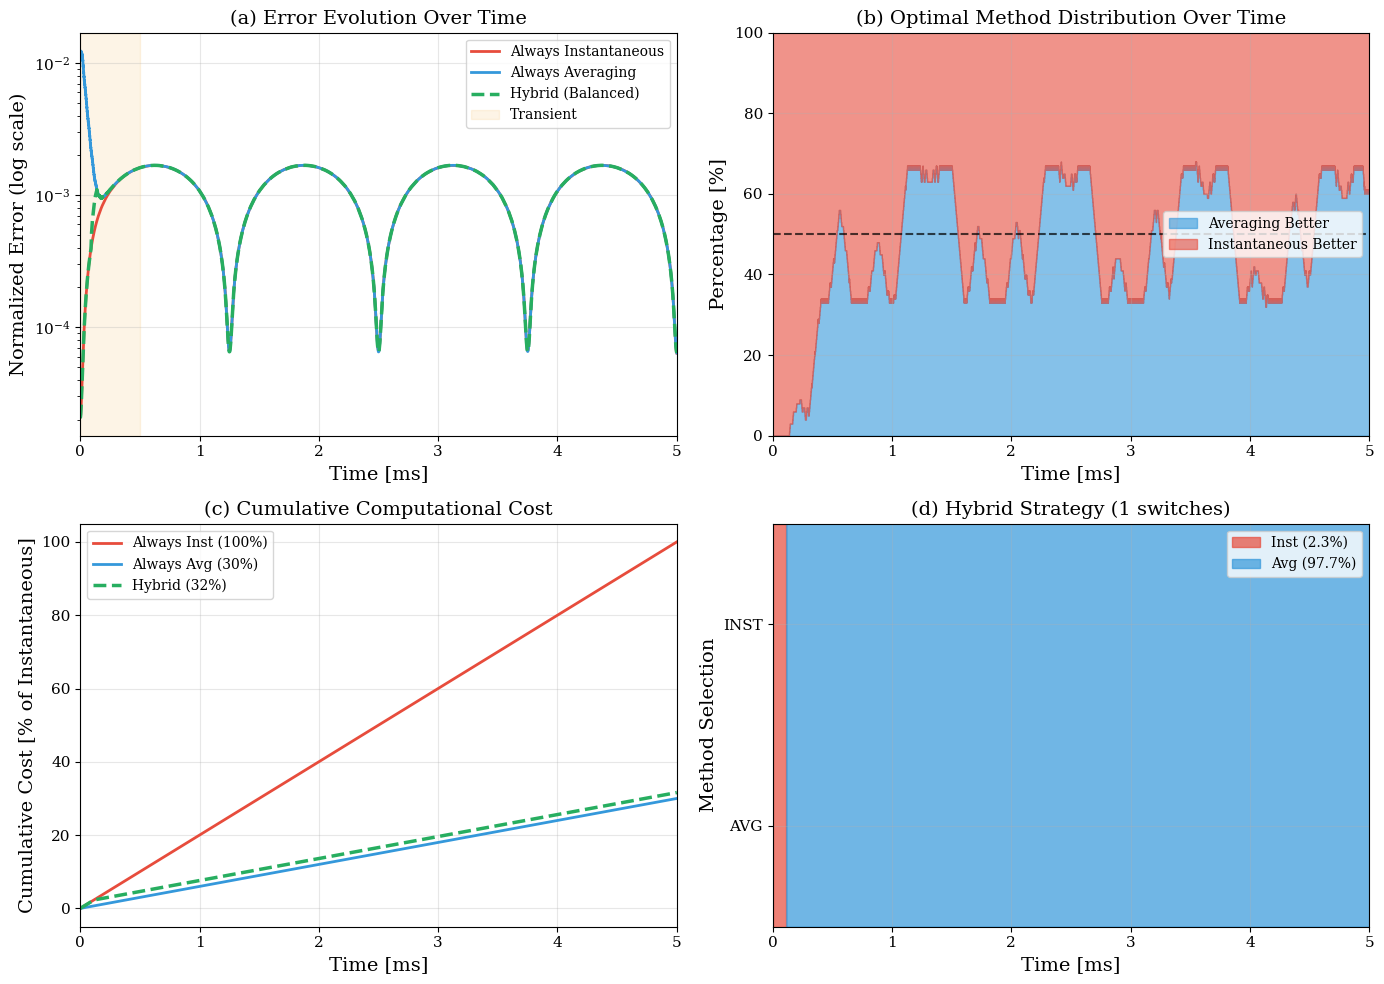


✓ Figures saved:
  • fig_error_evolution.png (300 DPI)
  • fig_error_evolution.pdf (vector)


In [18]:
# ============================================================
# CELL 8: Main Figure - Error Evolution
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
t_ms = t * 1e3

# Smooth errors for visualization
smooth_window = 50
err_inst_smooth = uniform_filter1d(err_inst, smooth_window)
err_avg_smooth = uniform_filter1d(err_avg, smooth_window)
err_hybrid_smooth = uniform_filter1d(hybrid_results['Balanced']['error_hybrid'], smooth_window)

# ===== Panel (a): Error over time =====
ax = axes[0, 0]
ax.semilogy(t_ms, err_inst_smooth, color=COLORS['instantaneous'], 
            label='Always Instantaneous', linewidth=2)
ax.semilogy(t_ms, err_avg_smooth, color=COLORS['averaging'], 
            label='Always Averaging', linewidth=2)
ax.semilogy(t_ms, err_hybrid_smooth, color=COLORS['hybrid'], 
            label='Hybrid (Balanced)', linewidth=2.5, linestyle='--')

ax.axvspan(0, 0.5, alpha=0.1, color=COLORS['transient'], label='Transient')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Normalized Error (log scale)')
ax.set_title('(a) Error Evolution Over Time')
ax.legend(loc='upper right', fontsize=10)
ax.set_xlim(0, t_ms[-1])
ax.grid(True, alpha=0.3)

# ===== Panel (b): Method selection fraction =====
ax = axes[0, 1]

# Compute rolling average of better_method
from scipy.ndimage import uniform_filter1d
window_size = 100
avg_better_rolling = uniform_filter1d(better_method.astype(float), window_size) * 100

ax.fill_between(t_ms, 0, avg_better_rolling,
                color=COLORS['averaging'], alpha=0.6, label='Averaging Better')
ax.fill_between(t_ms, avg_better_rolling, 100,
                color=COLORS['instantaneous'], alpha=0.6, label='Instantaneous Better')
ax.axhline(50, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

ax.set_xlabel('Time [ms]')
ax.set_ylabel('Percentage [%]')
ax.set_title('(b) Optimal Method Distribution Over Time')
ax.legend(loc='center right', fontsize=10)
ax.set_xlim(0, t_ms[-1])
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3)

# ===== Panel (c): Cumulative cost =====
ax = axes[1, 0]

dt_sim = t[1] - t[0]
cum_cost_inst = np.cumsum(np.ones(len(t)) * 1.0) * dt_sim * 1e3
cum_cost_avg = np.cumsum(np.ones(len(t)) * 0.3) * dt_sim * 1e3
cum_cost_hybrid = np.cumsum(hybrid_results['Balanced']['cost_per_step']) * dt_sim * 1e3

ax.plot(t_ms, cum_cost_inst / cum_cost_inst[-1] * 100, 
        color=COLORS['instantaneous'], label='Always Inst (100%)', linewidth=2)
ax.plot(t_ms, cum_cost_avg / cum_cost_inst[-1] * 100, 
        color=COLORS['averaging'], 
        label=f'Always Avg ({cum_cost_avg[-1]/cum_cost_inst[-1]*100:.0f}%)', linewidth=2)
ax.plot(t_ms, cum_cost_hybrid / cum_cost_inst[-1] * 100, 
        color=COLORS['hybrid'], 
        label=f'Hybrid ({cum_cost_hybrid[-1]/cum_cost_inst[-1]*100:.0f}%)', 
        linewidth=2.5, linestyle='--')

ax.set_xlabel('Time [ms]')
ax.set_ylabel('Cumulative Cost [% of Instantaneous]')
ax.set_title('(c) Cumulative Computational Cost')
ax.legend(loc='upper left', fontsize=10)
ax.set_xlim(0, t_ms[-1])
ax.grid(True, alpha=0.3)

# ===== Panel (d): Hybrid method selection =====
ax = axes[1, 1]

hr = hybrid_results['Balanced']
ax.fill_between(t_ms, 0, 1, where=hr['use_instantaneous'],
                color=COLORS['instantaneous'], alpha=0.7, 
                label=f'Inst ({hr["inst_fraction"]*100:.1f}%)', step='mid')
ax.fill_between(t_ms, 0, 1, where=~hr['use_instantaneous'],
                color=COLORS['averaging'], alpha=0.7,
                label=f'Avg ({(1-hr["inst_fraction"])*100:.1f}%)', step='mid')

ax.set_xlabel('Time [ms]')
ax.set_ylabel('Method Selection')
ax.set_title(f'(d) Hybrid Strategy ({hr["n_switches"]} switches)')
ax.legend(loc='upper right', fontsize=10)
ax.set_xlim(0, t_ms[-1])
ax.set_ylim(0, 1)
ax.set_yticks([0.25, 0.75])
ax.set_yticklabels(['AVG', 'INST'])
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('fig_error_evolution.png', dpi=300, bbox_inches='tight')
plt.savefig('fig_error_evolution.pdf', bbox_inches='tight')
plt.show()

print("\n✓ Figures saved:")
print("  • fig_error_evolution.png (300 DPI)")
print("  • fig_error_evolution.pdf (vector)")

---
## 6. Strategy Comparison Summary

In [19]:
# ============================================================
# CELL 9: Summary Table
# ============================================================

print("="*80)
print("STRATEGY COMPARISON SUMMARY")
print("="*80)

# Always instantaneous
print(f"\nAlways Instantaneous:")
print(f"  Mean Error: {np.mean(err_inst):.6f}")
print(f"  Max Error:  {np.max(err_inst):.6f}")
print(f"  Total Cost: 1.00 (baseline)")

# Always averaging
print(f"\nAlways Averaging:")
print(f"  Mean Error: {np.mean(err_avg):.6f}")
print(f"  Max Error:  {np.max(err_avg):.6f}")
print(f"  Total Cost: 0.30 (70% savings)")

# Hybrid strategies
for name, hr in hybrid_results.items():
    cost_total = np.mean(hr['cost_per_step'])
    print(f"\n{name} Hybrid:")
    print(f"  Mean Error: {np.mean(hr['error_hybrid']):.6f}")
    print(f"  Max Error:  {np.max(hr['error_hybrid']):.6f}")
    print(f"  Total Cost: {cost_total:.2f} ({(1-cost_total)*100:.0f}% savings)")
    print(f"  Switches:   {hr['n_switches']}")
    print(f"  Inst usage: {hr['inst_fraction']*100:.1f}%")

print("\n" + "="*80)

STRATEGY COMPARISON SUMMARY

Always Instantaneous:
  Mean Error: 0.001119
  Max Error:  0.001706
  Total Cost: 1.00 (baseline)

Always Averaging:
  Mean Error: 0.001251
  Max Error:  0.037300
  Total Cost: 0.30 (70% savings)

Aggressive Hybrid:
  Mean Error: 0.001123
  Max Error:  0.001708
  Total Cost: 0.32 (68% savings)
  Switches:   1
  Inst usage: 2.7%

Balanced Hybrid:
  Mean Error: 0.001125
  Max Error:  0.002133
  Total Cost: 0.32 (68% savings)
  Switches:   1
  Inst usage: 2.3%

Conservative Hybrid:
  Mean Error: 0.001119
  Max Error:  0.001708
  Total Cost: 0.37 (63% savings)
  Switches:   1
  Inst usage: 10.0%

